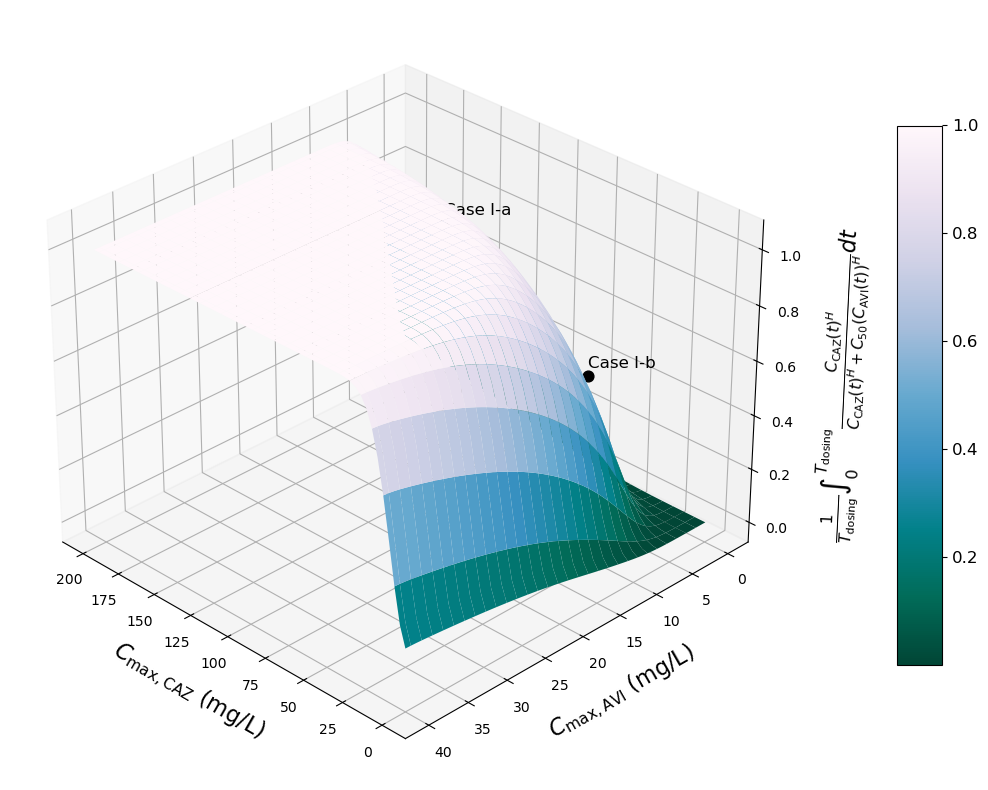

In [54]:
#Figure_17

from scipy.ndimage import gaussian_filter
from matplotlib import colormaps
from matplotlib.colors import LightSource, Normalize
from matplotlib.cm import ScalarMappable
from scipy.integrate import quad

H = 12.8
t_half = 2.5
T_period = 6.0
T0 = 2.0
a, b, c = -0.797, 0.933, -1.301

def C_t(t, C_max):
    f0 = 2 ** (-(T_period - T0) / t_half)
    if t <= T0:
        return C_max * (f0 * (1 - t / T0) + t / T0)
    else:
        return C_max * 2 ** (-(t - T0) / t_half)

def r_min(t, C_max_CAZ, C_max_AVI):
    C_CAZ_t = C_t(t, C_max_CAZ)
    C_AVI_t = C_t(t, C_max_AVI)
    log10_C50 = a / (b ** C_AVI_t + c)
    C50 = 10 ** log10_C50
    num = C_CAZ_t ** H
    return num / (num + C50 ** H)

CAZ_vals = np.linspace(0, 200, 60)
AVI_vals = np.linspace(0, 40, 60)
X, Y = np.meshgrid(CAZ_vals, AVI_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        integral, _ = quad(lambda t: r_min(t, X[i, j], Y[i, j]), 0, T_period, limit=100)
        Z[i, j] = integral / T_period

Z_smooth = gaussian_filter(Z, sigma=2.0)

Cmax_CAZ_a, Cmax_AVI_a = 100, 15
integral_a, _ = quad(lambda t: r_min(t, Cmax_CAZ_a, Cmax_AVI_a), 0, T_period, limit=100)
Z_a = integral_a / T_period

Cmax_CAZ_b, Cmax_AVI_b = 50, 6
integral_b, _ = quad(lambda t: r_min(t, Cmax_CAZ_b, Cmax_AVI_b), 0, T_period, limit=100)
Z_b = integral_b / T_period

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

norm = Normalize(vmin=np.min(Z_smooth), vmax=np.max(Z_smooth))
cmap = plt.colormaps.get_cmap('PuBuGn_r')
surf = ax.plot_surface(X, Y, Z_smooth, cmap=cmap, norm=norm, edgecolor='none', linewidth=0, antialiased=True, alpha=1)

ax.scatter(Cmax_CAZ_a, Cmax_AVI_a, Z_a+0.03, color='k', s=60, zorder=10)
ax.text(Cmax_CAZ_a, Cmax_AVI_a, Z_a+0.06, "Case I-a", fontsize=12, color='k')
ax.scatter(Cmax_CAZ_b, Cmax_AVI_b, Z_b+0.03, color='k', s=60, zorder=10)
ax.text(Cmax_CAZ_b, Cmax_AVI_b, Z_b+0.06, "Case I-b", fontsize=12, color='k')

ax.set_xlabel(r'$C_{\mathrm{max,CAZ}}$ (mg/L)', fontsize=16, labelpad=10)
ax.set_ylabel(r'$C_{\mathrm{max,AVI}}$ (mg/L)', fontsize=16, labelpad=10)
ax.set_zlabel(r'$\frac{1}{T_{\mathrm{dosing}}} \int_0^{T_{\mathrm{dosing}}} \frac{C_{\mathrm{CAZ}}(t)^H}{C_{\mathrm{CAZ}}(t)^H + C_{50}(C_{\mathrm{AVI}}(t))^H} dt$', fontsize=16, labelpad=15)

mappable = ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = plt.colorbar(mappable, ax=ax, shrink=0.7, aspect=12, pad=0.1)
cbar.ax.tick_params(labelsize=12)

ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.show()


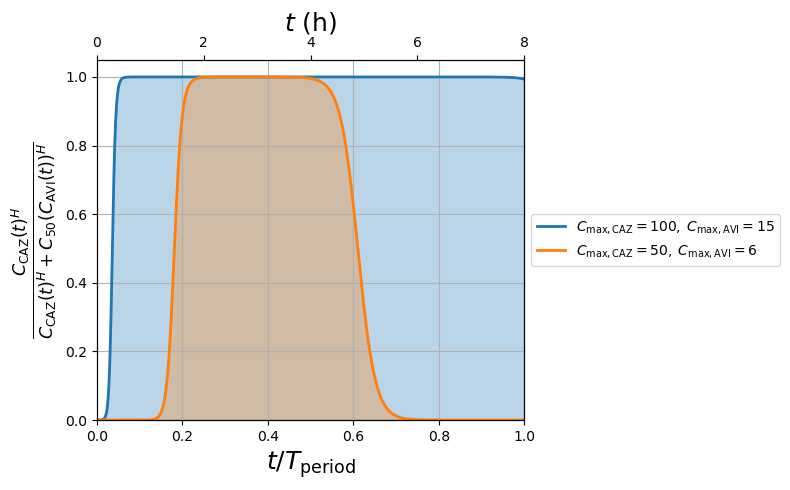

In [56]:
#Figure_18

H = 12.8
a, b, c = -0.797, 0.933, -1.301
T_period = 6
t = np.linspace(0, T_period, 500)
t_norm = t / T_period

def C_t(Cmax, T0, Tperiod, t_half, t):
    kel  = np.log(2) / t_half
    A    = 2 ** (-(Tperiod - T0)/t_half)
    C    = np.zeros_like(t)
    mask = t <= T0
    C[mask]  = Cmax * (A * (1 - t[mask]/T0) + t[mask]/T0)
    C[~mask] = Cmax * 2 ** (-(t[~mask] - T0)/t_half)
    return C

scenarios = [
    dict(Cmax_CAZ=100, Cmax_AVI=15, color='#1f77b4',
         label=r'$C_{\max,\mathrm{CAZ}}=100,\;C_{\max,\mathrm{AVI}}=15$'),
    dict(Cmax_CAZ=50,  Cmax_AVI=6,  color='#ff7f0e',
         label=r'$C_{\max,\mathrm{CAZ}}=50,\;C_{\max,\mathrm{AVI}}=6$')
]

fig, ax = plt.subplots(figsize=(8, 5))

for sc in scenarios:
    C_CAZ = C_t(sc["Cmax_CAZ"], T0=2, Tperiod=8, t_half=2.5, t=t)
    C_AVI = C_t(sc["Cmax_AVI"], T0=2, Tperiod=8, t_half=2.5, t=t)
    denom = b**C_AVI + c
    C50 = 10**(a / denom)
    num = C_CAZ**H
    E = num / (num + C50**H)
    ax.fill_between(t_norm, 0, E, color=sc["color"], alpha=0.3)
    ax.plot(t_norm, E, color=sc["color"], lw=2, label=sc["label"])

ax.set_xlabel(r'$t/T_{\mathrm{period}}$',fontsize=18)
ax.set_ylabel(r'$\frac{C_{\mathrm{CAZ}}(t)^H}{C_{\mathrm{CAZ}}(t)^H + C_{50}(C_{\mathrm{AVI}}(t))^H}$', fontsize=18)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.grid(True)

ax_top = ax.twiny()
ax_top.set_xlim(0, 1)
ax_top.set_xticks(np.linspace(0, 1, 5))
ax_top.set_xticklabels(['0', '2', '4', '6', '8'])
ax_top.set_xlabel(r'$t$ (h)',fontsize=18)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()


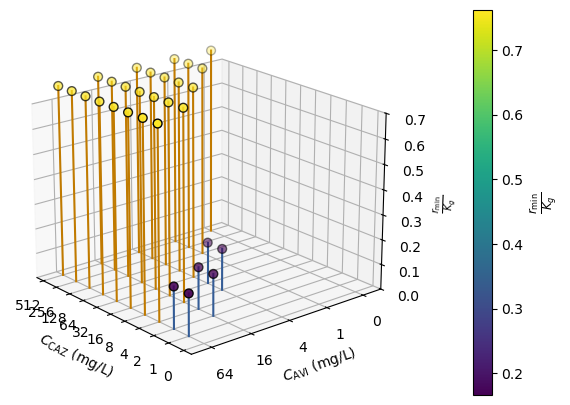

In [97]:
#Figure_19

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

CAZ = np.array([0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
AVI = np.array([0, 1, 4, 16, 64])

TTP = np.array([
    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 21],
    [5, 5, 5, 5, 5, 5, 5, 5, 21, 21, 21],
    [5, 5, 5, 5, 6, 6, 21, 21, 21, 21, 21],
    [5, 5, 6, 6, 21, 21, 21, 21, 21, 21, 21],
    [5, 6, 6, 21, 21, 21, 21, 21, 21, 21, 21]
])

rminKg = 1 - 5 / np.minimum(TTP, 21)
mask_lower = TTP >= 21

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

x_idx = np.arange(len(CAZ))
y_idx = np.arange(len(AVI))

X, Y, Z, C = [], [], [], []

for i, y in enumerate(y_idx):
    for j, x in enumerate(x_idx):
        z = rminKg[i, j]
        if z == 0:
            continue
        stem_color = '#c07a00' if mask_lower[i, j] else '#345c96'
        ax.plot([x, x], [y, y], [0, z], color=stem_color, lw=1.5)

        X.append(x)
        Y.append(y)
        Z.append(z)
        C.append(z)

sc = ax.scatter(X, Y, Z, c=C, cmap='viridis', s=40, edgecolor='k')

cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label(r"$\frac{r_{\min}}{K_g}$", fontsize=12)

ax.set_xticks(x_idx)
ax.set_xticklabels([str(v) for v in CAZ])
ax.set_yticks(y_idx)
ax.set_yticklabels([str(v) for v in AVI])
ax.set_xlabel(r'$C_{\mathrm{CAZ}}$ (mg/L)')
ax.set_ylabel(r'$C_{\mathrm{AVI}}$ (mg/L)')
ax.set_zlabel(r'$\frac{r_{\min}}{K_g}$')
ax.set_xlim(-0.5, len(CAZ)-0.5)
ax.set_ylim(-0.5, len(AVI)-0.5)
ax.set_zlim(0, 0.7)
ax.view_init(elev=20, azim=140)

plt.show()
